# Topas Work - Team protons and heavy ions
### PHY-7051 Physique des radiations en radiothérapie et en radiologie
Gabrielle Germain (111 266 117), Hanieh Sadat Jozi (111 XXX XXX), Philippe Dionne (111 XXX XXX)

In [6]:
import numpy as np
import matplotlib.pyplot as plt

Useful functions

In [7]:
def csv_to_data(path:str, skiprows:int=9, delimiter:str=', ') -> tuple:
    """ Reads the csv file and converts it to a tuple containing 3 columns matrices

    Args:
        path (str): absolute path on the computer. Must have the format r"C:\path.csv"
        skiprows (int, optional): Rows to skip the header. Defaults to 9.
        delimiter (str, optional): Defaults to ', '.

    Returns:
        tuple: (bin, dose, standard-deviation)
    """

    data = np.loadtxt(path, skiprows=skiprows, delimiter=delimiter, usecols=(2, 3, 4))
    bin = data[:, 0]
    dose = data[:, 1]
    std = data[:, 2]
    return (bin, dose, std)

Constants

In [8]:
MeV_to_joule = 1.602176565e-13 # J/MeV

## Central-axis depth-dose distribution in water of a monoenergetic beam of protons or carbon ions

Premier essai: avec seulement un module physique ("g4em-standard_opt4")

Protons de  122 MeV - Erreur relative suffisante atteinte!
0.025 % < 3 %
Protons de  183 MeV - Erreur relative suffisante atteinte!
0.0167 % < 3 %
Protons de  230 MeV - Erreur relative suffisante atteinte!
0.00162 % < 3 %
Ion de carbone de  220 MeV/u - Erreur relative suffisante atteinte!
0.241 % < 3 %
Ion de carbone de  350 MeV/u - Erreur relative suffisante atteinte!
0.147 % < 3 %
Ion de carbone de  430 MeV/u - Erreur relative suffisante atteinte!
0.0157 % < 3 %


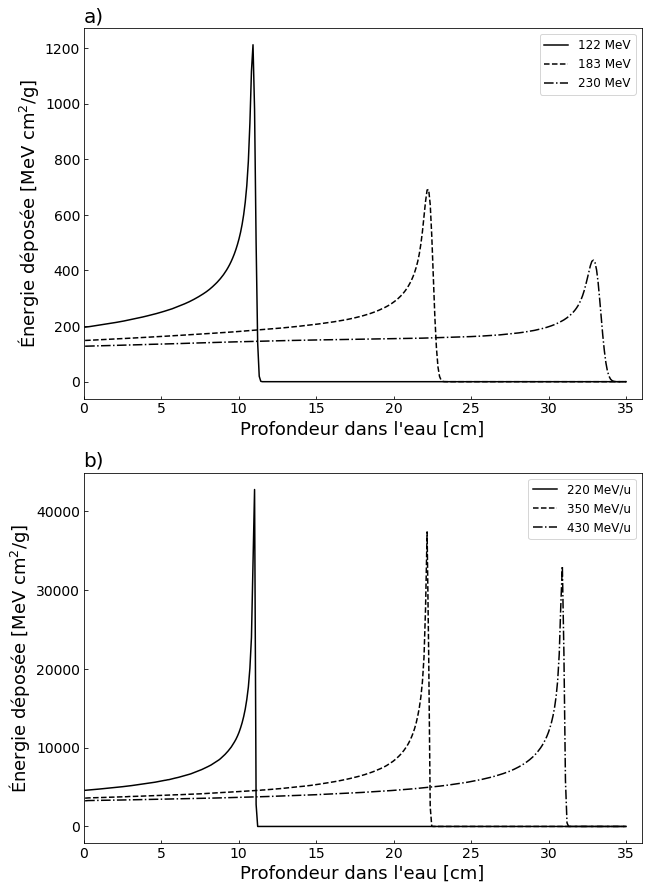

In [32]:
""" Le code ci-bas génère la figure 6.12 du manuel de référence, soit le dépôt de la dose à différentes profondeurs dans un fantôme d'eau.
C'est une première tentative qui ne fonctionnait pas tout à fait... Néanmoins, les résultats sont intéressants"""

# ------------------------------- Paramètres ------------------------------------------- #
""" Initialisation des paramètres utilisés dans les codes de simulation TOPAS. """

field_size = 100 # cm2
energies_p = np.array([122, 183, 230])      # MeV
energies_c = np.array([220, 350, 430])      # MeV/u, u = 12
nbr_p = np.array([1000000, 1000000, 1000000]) # nbr de protons simulés pour chaque énergie
nbr_c = np.array([10000, 10000, 100000]) # nbr d'ions de carbone simulés pour chaque énergie
tot_depths = np.array([35, 35]) # profondeur des scorers pour chaque particule, en cm
in_fluence_p = nbr_p/field_size # cm-2
in_fluence_c = nbr_c/field_size # cm-2

np.seterr(divide='ignore', invalid='ignore')

# initialisation des données
std_rel_p = np.empty(np.size(energies_p))
R50_p = np.empty(np.size(energies_p))
Dmax_p = np.empty(np.size(energies_p))

std_rel_c = np.empty(np.size(energies_c))
R50_c = np.empty(np.size(energies_c))
Dmax_c = np.empty(np.size(energies_c))

# initialisation des figures
fig1 = plt.figure(figsize=(10, 15))
ax1 = plt.subplot(2, 1, 1)      # protons
plt.xlabel("Profondeur dans l'eau [cm]", fontsize='18')
plt.ylabel("Énergie déposée [MeV cm$^2$/g]", fontsize='18')
plt.title("a)",  fontsize='20', loc="left")
plt.tick_params(direction='in',labelsize='14')
ax2 = plt.subplot(2, 1, 2)      # carbone
plt.xlabel("Profondeur dans l'eau [cm]", fontsize='18')
plt.ylabel("Énergie déposée [MeV cm$^2$/g]", fontsize='18')
plt.title("b)",  fontsize='20', loc="left")
plt.tick_params(direction='in',labelsize='14')

marker = ['-','--','-.',':','k-','k--','k-.','k:']

# ------------------------------- Fonctions de calcul ------------------------------------------- #
## Protons en premier
for i in range(len(energies_p)):
    energy = energies_p[i]
    path = r"C:\Users\gabri\Documents\Université\Maitrise\Session 1\physique_radiations\Devoir\Topas_project\Figure6_12\6_12_protons_{}MeV_broad.csv".format(energy)
    bins, dose, std = csv_to_data(path)

    # erreur relative
    std_rel_p[i] = (np.nanmean(std/dose))*100 # % erreur moyenne sur mesure de dose
    if std_rel_p[i] < 3: # erreur maximale est choisie à 3%
        print("Protons de ", energy, "MeV - Erreur relative suffisante atteinte!")
        print(format(std_rel_p[i], '.3g'), "% <", "3 %")
    else:
        print("Protons de ", energy, "MeV - Erreur relative trop élevée")
        print(format(std_rel_p[i], '.3g'), "% >", "3 %")

    # conversion dose et profondeur
    depth = bins * tot_depths[0]/len(bins)
    dose = dose/(1000*MeV_to_joule*in_fluence_p[i]) # MeV cm2/g, conversion des MeV en Joule et normalisation par la fluence initiale

    # Figure
    ax1.plot(depth, dose, marker[i], label="{} MeV".format(energy), color="k")

ax1.set_xlim([0, 36])
# ax1.set_ylim([0, 1250])
ax1.legend(loc=0, frameon=True, fontsize='12')

## Carbone en second
for i in range(len(energies_c)):
    energy = energies_c[i]
    path = r"C:\Users\gabri\Documents\Université\Maitrise\Session 1\physique_radiations\Devoir\Topas_project\Figure6_12\6_12_carbon_{}MeV_broad.csv".format(energy)
    bins, dose, std = csv_to_data(path)

    # erreur relative
    std_rel_c[i] = (np.nanmean(std/dose))*100 # % erreur moyenne sur mesure de dose
    if std_rel_c[i] < 3: # erreur maximale est choisie à 3%
        print("Ion de carbone de ", energy, "MeV/u - Erreur relative suffisante atteinte!")
        print(format(std_rel_c[i], '.3g'), "% <", "3 %")
    else:
        print("Ion de carbone ", energy, "MeV/u - Erreur relative trop élevée")
        print(format(std_rel_c[i], '.3g'), "% >", "3 %")

    # conversion dose et profondeur
    depth = bins * tot_depths[1]/len(bins)
    dose = dose/(1000*MeV_to_joule*in_fluence_c[i]) # MeV cm2/g, conversion des MeV en Joule et normalisation par la fluence initiale

    # Figure
    ax2.plot(depth, dose, marker[i], label="{} MeV/u".format(energy), color="k")

ax2.set_xlim([0, 36])
# ax2.set_ylim([0, 45000])
ax2.legend(loc=0, frameon=True, fontsize='12')



Deuxième essai avec plus de modules physique:

sv:Ph/Default/Modules = 6 "g4em-standard_opt4" "g4h-phy_QGSP_BIC_HP" "g4decay" "g4ion-binarycascade" "g4h-elastic_HP" "g4stopping"

On peut maintenant voir les effets des réactions nucléaires

Protons de  122 MeV - Erreur relative suffisante atteinte!
0.157 % < 3 %
Protons de  183 MeV - Erreur relative suffisante atteinte!
0.0924 % < 3 %
Protons de  230 MeV - Erreur relative suffisante atteinte!
0.00884 % < 3 %
Ion de carbone de  220 MeV/u - Erreur relative suffisante atteinte!
0.143 % < 3 %
Ion de carbone de  350 MeV/u - Erreur relative suffisante atteinte!
0.0452 % < 3 %
Ion de carbone de  430 MeV/u - Erreur relative suffisante atteinte!
0.0263 % < 3 %


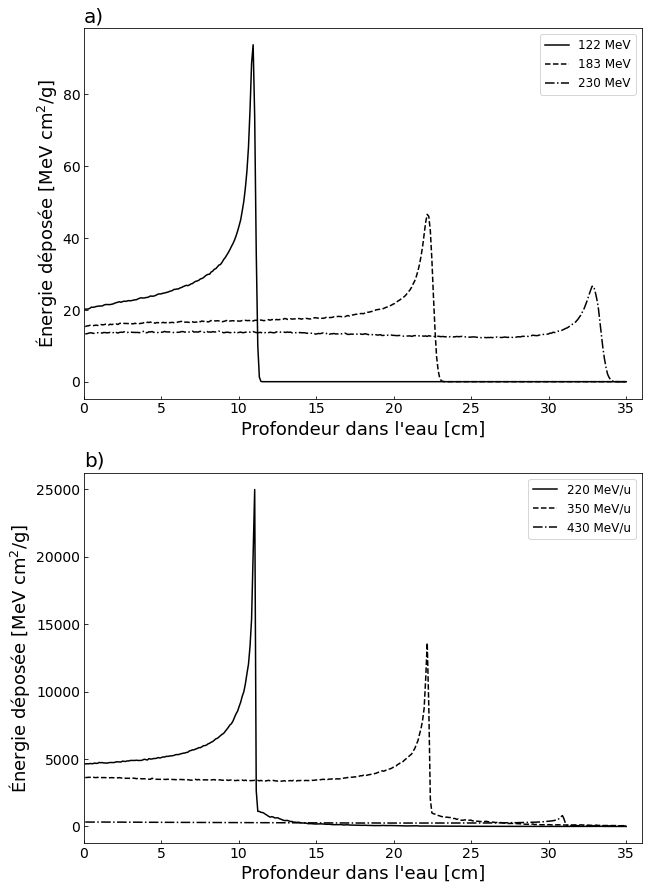

In [30]:
""" Le code ci-bas génère la figure 6.12 du manuel de référence, soit soit le dépôt de la dose à différentes profondeurs dans un fantôme d'eau."""

# ------------------------------- Paramètres ------------------------------------------- #
""" Initialisation des paramètres utilisés dans les codes de simulation TOPAS. """

field_size = 100 # cm2
energies_p = np.array([122, 183, 230])      # MeV
energies_c = np.array([220, 350, 430])      # MeV/u, u = 12
nbr_p = np.array([1000000, 1000000, 1000000]) # nbr de protons simulés pour chaque énergie
nbr_c = np.array([10000, 10000, 100000]) # nbr d'ions de carbone simulés pour chaque énergie
tot_depths = np.array([35, 35]) # profondeur des scorers pour chaque particule, en cm
in_fluence_p = nbr_p/field_size # cm-2
in_fluence_c = nbr_c/field_size # cm-2

np.seterr(divide='ignore', invalid='ignore')

# initialisation des données
std_rel_p = np.empty(np.size(energies_p))
R50_p = np.empty(np.size(energies_p))
Dmax_p = np.empty(np.size(energies_p))

std_rel_c = np.empty(np.size(energies_c))
R50_c = np.empty(np.size(energies_c))
Dmax_c = np.empty(np.size(energies_c))

# initialisation des figures
fig1 = plt.figure(figsize=(10, 15))
ax1 = plt.subplot(2, 1, 1)      # protons
plt.xlabel("Profondeur dans l'eau [cm]", fontsize='18')
plt.ylabel("Énergie déposée [MeV cm$^2$/g]", fontsize='18')
plt.title("a)",  fontsize='20', loc="left")
plt.tick_params(direction='in',labelsize='14')
ax2 = plt.subplot(2, 1, 2)      # carbone
plt.xlabel("Profondeur dans l'eau [cm]", fontsize='18')
plt.ylabel("Énergie déposée [MeV cm$^2$/g]", fontsize='18')
plt.title("b)",  fontsize='20', loc="left")
plt.tick_params(direction='in',labelsize='14')

marker = ['-','--','-.',':','k-','k--','k-.','k:']

# ------------------------------- Fonctions de calcul ------------------------------------------- #
## Protons en premier
for i in range(len(energies_p)):
    energy = energies_p[i]
    path = r"C:\Users\gabri\Documents\Université\Maitrise\Session 1\physique_radiations\Devoir\Topas_project\Figure6_12\6_12_protons_{}MeV.csv".format(energy)
    bins, dose, std = csv_to_data(path)

    # erreur relative
    std_rel_p[i] = (np.nanmean(std/dose))*100 # % erreur moyenne sur mesure de dose
    if std_rel_p[i] < 3: # erreur maximale est choisie à 3%
        print("Protons de ", energy, "MeV - Erreur relative suffisante atteinte!")
        print(format(std_rel_p[i], '.3g'), "% <", "3 %")
    else:
        print("Protons de ", energy, "MeV - Erreur relative trop élevée")
        print(format(std_rel_p[i], '.3g'), "% >", "3 %")

    # conversion dose et profondeur
    depth = bins * tot_depths[0]/len(bins)
    dose = dose/(1000*MeV_to_joule*in_fluence_p[i]) # MeV cm2/g, conversion des MeV en Joule et normalisation par la fluence initiale

    # Figure
    ax1.plot(depth, dose, marker[i], label="{} MeV".format(energy), color="k")

ax1.set_xlim([0, 36])
# ax1.set_ylim([0, 1250])
ax1.legend(loc=0, frameon=True, fontsize='12')

## Carbone en second
for i in range(len(energies_c)):
    energy = energies_c[i]
    path = r"C:\Users\gabri\Documents\Université\Maitrise\Session 1\physique_radiations\Devoir\Topas_project\Figure6_12\6_12_carbon_{}MeV.csv".format(energy)
    bins, dose, std = csv_to_data(path)

    # erreur relative
    std_rel_c[i] = (np.nanmean(std/dose))*100 # % erreur moyenne sur mesure de dose
    if std_rel_c[i] < 3: # erreur maximale est choisie à 3%
        print("Ion de carbone de ", energy, "MeV/u - Erreur relative suffisante atteinte!")
        print(format(std_rel_c[i], '.3g'), "% <", "3 %")
    else:
        print("Ion de carbone ", energy, "MeV/u - Erreur relative trop élevée")
        print(format(std_rel_c[i], '.3g'), "% >", "3 %")

    # conversion dose et profondeur
    depth = bins * tot_depths[1]/len(bins)
    dose = dose/(1000*MeV_to_joule*in_fluence_c[i]) # MeV cm2/g, conversion des MeV en Joule et normalisation par la fluence initiale

    # Figure
    ax2.plot(depth, dose, marker[i], label="{} MeV/u".format(energy), color="k")

ax2.set_xlim([0, 36])
# ax2.set_ylim([0, 45000])
ax2.legend(loc=0, frameon=True, fontsize='12')



Ion de carbone de  220 MeV/u - Erreur relative suffisante atteinte!
0.143 % < 3 %
Ion de carbone de  350 MeV/u - Erreur relative suffisante atteinte!
0.0452 % < 3 %
Ion de carbone de  430 MeV/u - Erreur relative suffisante atteinte!
0.0263 % < 3 %


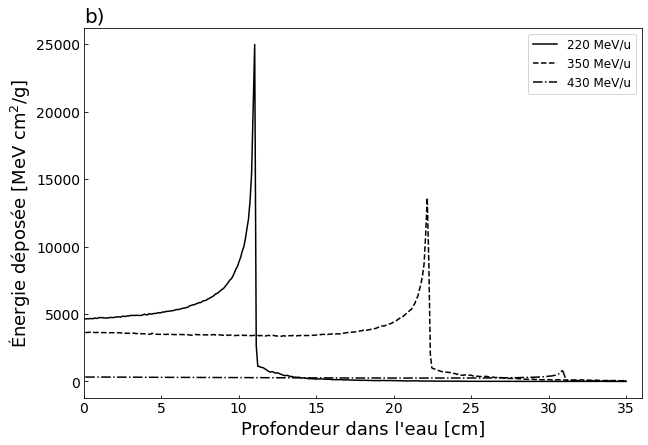

In [31]:
"""Essai avec modules suivants (script carbone_testmodules1.txt): sv:Ph/Default/Modules = 2 "g4em-standard_opt4" "g4h-phy_QGSP_BIC_HP"
carbone, mêmes énergies qu'avant"""

# ------------------------------- Paramètres ------------------------------------------- #
""" Initialisation des paramètres utilisés dans les codes de simulation TOPAS. """

field_size = 100 # cm2
energies_p = np.array([122, 183, 230])      # MeV
energies_c = np.array([220, 350, 430])      # MeV/u, u = 12
nbr_p = np.array([1000000, 1000000, 1000000]) # nbr de protons simulés pour chaque énergie
nbr_c = np.array([10000, 10000, 100000]) # nbr d'ions de carbone simulés pour chaque énergie
tot_depths = np.array([35, 35]) # profondeur des scorers pour chaque particule, en cm
in_fluence_p = nbr_p/field_size # cm-2
in_fluence_c = nbr_c/field_size # cm-2

np.seterr(divide='ignore', invalid='ignore')

# initialisation des données
std_rel_p = np.empty(np.size(energies_p))
R50_p = np.empty(np.size(energies_p))
Dmax_p = np.empty(np.size(energies_p))

std_rel_c = np.empty(np.size(energies_c))
R50_c = np.empty(np.size(energies_c))
Dmax_c = np.empty(np.size(energies_c))

# initialisation des figures
fig1 = plt.figure(figsize=(10, 15))
# ax1 = plt.subplot(2, 1, 1)      # protons
# plt.xlabel("Profondeur dans l'eau [cm]", fontsize='18')
# plt.ylabel("Énergie déposée [MeV cm$^2$/g]", fontsize='18')
# plt.title("a)",  fontsize='20', loc="left")
# plt.tick_params(direction='in',labelsize='14')
ax2 = plt.subplot(2, 1, 2)      # carbone
plt.xlabel("Profondeur dans l'eau [cm]", fontsize='18')
plt.ylabel("Énergie déposée [MeV cm$^2$/g]", fontsize='18')
plt.title("b)",  fontsize='20', loc="left")
plt.tick_params(direction='in',labelsize='14')

marker = ['-','--','-.',':','k-','k--','k-.','k:']


# ------------------------------- Fonctions de calcul ------------------------------------------- #
for i in range(len(energies_c)):
    energy = energies_c[i]
    path = r"C:\Users\gabri\Documents\Université\Maitrise\Session 1\physique_radiations\Devoir\Topas_project\Figure6_12\6_12_carbon_{}MeV.csv".format(energy)
    bins, dose, std = csv_to_data(path)

    # erreur relative
    std_rel_c[i] = (np.nanmean(std/dose))*100 # % erreur moyenne sur mesure de dose
    if std_rel_c[i] < 3: # erreur maximale est choisie à 3%
        print("Ion de carbone de ", energy, "MeV/u - Erreur relative suffisante atteinte!")
        print(format(std_rel_c[i], '.3g'), "% <", "3 %")
    else:
        print("Ion de carbone ", energy, "MeV/u - Erreur relative trop élevée")
        print(format(std_rel_c[i], '.3g'), "% >", "3 %")

    # conversion dose et profondeur
    depth = bins * tot_depths[1]/len(bins)
    dose = dose/(1000*MeV_to_joule*in_fluence_c[i]) # MeV cm2/g, conversion des MeV en Joule et normalisation par la fluence initiale

    # Figure
    ax2.plot(depth, dose, marker[i], label="{} MeV/u".format(energy), color="k")

ax2.set_xlim([0, 36])
# ax2.set_ylim([0, 45000])
ax2.legend(loc=0, frameon=True, fontsize='12')


## Depth of the Bragg Peak for a carbon ions beam

## Beam quality of a pristine and modulated beam of proton